# Supervised Learning of Drug Response using CORES from Copy Number Log Ratio

### Import Python source code

In [67]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 26 12:21:38 2018

@author: bbece
"""

from __future__ import division, print_function, unicode_literals
import numpy as np
import os
from IPython.display import display, HTML

from pprint import pprint
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
            
import pandas as pd
import scipy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import math



### Define method to split training and testing set

In [2]:
# TODO: Manipulate test_ratio
def split_train_test(training_set, test_ratio = 0.33):
    row_count = training_set.shape[0]
    shuffled_indices = np.random.permutation(row_count)
    test_set_size = int(test_ratio * row_count)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return training_set.iloc[train_indices], training_set.iloc[test_indices]

### Load training set matrix

In [8]:
labeled_matrix_training_set = pd.read_csv("../mlOutput/coreTrainingSet_7_31_2018_1.csv")
labeled_matrix_training_set.columns.values[0] = "sampleId"
labels = list(range(0,5))


In [4]:
pprint(labeled_matrix_training_set.copy().head())

  sampleId  Gemcitabine  Paclitaxel     SN-38      5-FU  Oxaliplatin  \
0    hM17D     0.637520    0.652945  0.679371  0.822522     0.927028   
1    hM19A     0.744417    0.667870  0.563638  0.839585     0.874489   
2    hM19B     0.736595    0.697379  0.606223  0.909020     0.939280   
3    hM19C     0.672706    0.631027  0.590799  0.641945     0.924407   
4    hM19D     0.585682    0.614227  0.579178  0.583491          NaN   

          1         4         6         8    ...           43        44  \
0 -0.191476 -0.111982 -0.031535  0.194702    ...    -0.180308 -0.388883   
1  0.117598  0.049725  0.292631 -0.521739    ...     0.126315 -0.115778   
2 -0.516071 -0.485236  0.178861 -0.645285    ...     0.096073 -0.113105   
3 -0.494288 -0.585292  0.200625 -0.543859    ...    -0.012848 -0.207628   
4 -0.548347 -0.512629  0.188757 -0.508282    ...     0.105863 -0.005723   

         45        46        47        48        49        50        52  \
0 -0.254426 -0.132726 -0.228261  0.044768

### Preprocess/Transform input training matrix

* Impute NaN values using the median of the column
* Standardize all values

In [58]:
imputer = Pipeline([
    ('imputer', Imputer(strategy="median"))
])

standardizer = Pipeline([
    ('std_scaler', StandardScaler())
])


imputed = imputer.fit_transform(labeled_matrix_training_set.copy().drop(["sampleId"], axis=1))
processed_training_set = standardizer.fit_transform(imputed)

In [59]:
print(processed_training_set)

[[-0.23330645  0.49943843  1.55282057 ...,  1.67485858  1.5745206  -0.827832  ]
 [ 1.62726726  0.7561883  -0.68340642 ..., -0.36018446  1.14115059
   1.02234566]
 [ 1.49112882  1.26379274  0.13942341 ..., -0.23270269  1.22492635
   1.15149628]
 ..., 
 [-0.09129981 -0.1330282  -0.24584731 ...,  0.70908473 -0.23126266
   0.83869058]
 [-0.09129981 -0.1330282  -0.24584731 ..., -0.24434973  1.1203276
  -0.24567415]
 [-1.03470437 -1.12981741 -1.33191931 ..., -1.15449277 -0.33156476
  -1.343845  ]]


In [60]:
final_training_set = pd.DataFrame(data=processed_training_set, columns = labeled_matrix_training_set.columns[1:])
print(final_training_set.copy().head())

   Gemcitabine  Paclitaxel     SN-38      5-FU  Oxaliplatin         1  \
0    -0.233306    0.499438  1.552821  0.300075     1.348759 -0.065255   
1     1.627267    0.756188 -0.683406  0.507795     0.412063  1.173183   
2     1.491129    1.263793  0.139423  1.353072     1.567209 -1.365884   
3     0.379110    0.122420 -0.158585 -1.898187     1.302047 -1.278601   
4    -1.135565   -0.166577 -0.383144 -2.609772     0.135110 -1.495213   

          4         6         8         9    ...           43        44  \
0  0.405571 -0.439825  0.520059  0.656853    ...    -1.018458 -0.183203   
1  1.086715  0.646296 -1.200589 -1.245120    ...     0.877814  0.523227   
2 -1.166652  0.265109 -1.497303 -1.386605    ...     0.690787  0.530142   
3 -1.588107  0.338029 -1.253714 -1.326183    ...     0.017176  0.285641   
4 -1.282036  0.298265 -1.168269 -1.335386    ...     0.751333  0.807904   

         45        46        47        48        49        50        52  \
0 -0.293263 -0.465442  0.102553 -1.

## Visualize ML Results

In [61]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

### Visualize ML results using Linear Regression

0.402137774215
Pearson: (0.93664085837054423, 1.069236791522125e-08)
Spearman: SpearmanrResult(correlation=0.79566563467492246, pvalue=7.8668718397328902e-05)


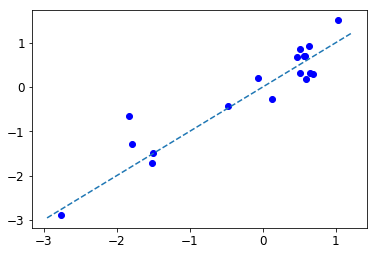

0.668562656333
Pearson: (0.89993041247671779, 3.6787364402741666e-07)
Spearman: SpearmanrResult(correlation=0.73374613003095968, pvalue=0.0005283926713947288)


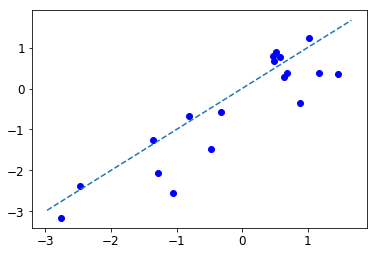

0.525109756909
Pearson: (0.91747241373144872, 8.3309799467912179e-08)
Spearman: SpearmanrResult(correlation=0.80804953560371517, pvalue=4.9748622797470908e-05)


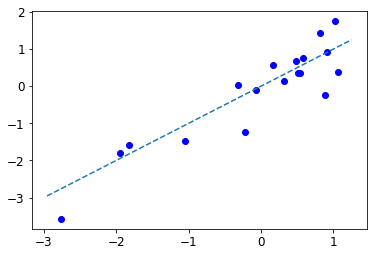

0.618302305808
Pearson: (0.77818648171208371, 0.00014292983597030009)
Spearman: SpearmanrResult(correlation=0.65737874097007221, pvalue=0.0030302895427941658)


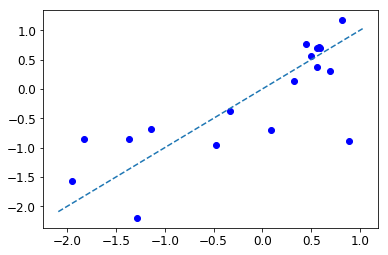

0.48056440534
Pearson: (0.94817441552953563, 2.2228667515979897e-09)
Spearman: SpearmanrResult(correlation=0.79772961816305465, pvalue=7.3041347096630552e-05)


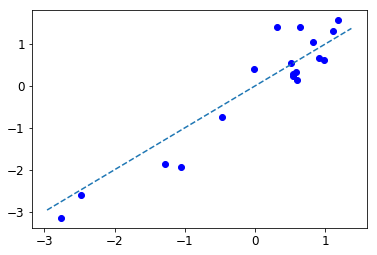

In [62]:
for label in labels:
    # Remove uneeded labels
    selected_training_set = final_training_set.iloc[:, list([label]) + list(range(5,final_training_set.shape[1]))].copy()
    selected_training_set = selected_training_set[np.isfinite(selected_training_set.iloc[:,1])]
    training_set, testing_set = split_train_test(selected_training_set)
    model_data = training_set.copy().drop([training_set.columns[0], training_set.columns[1]], axis = 1)
    model_labels = training_set.iloc[:,1]
    lasso = LinearRegression()
    lasso.fit(model_data, model_labels)
    model_test_data = testing_set.copy().drop([training_set.columns[0], training_set.columns[1]], axis = 1)
    model_test_labels = testing_set.iloc[:,1]
    predictions = lasso.predict(model_test_data)
    mse = mean_squared_error(model_test_labels, predictions)
    rmse = np.sqrt(mse)
    print(rmse)
    r = scipy.stats.pearsonr(model_test_labels, predictions)
    t = scipy.stats.spearmanr(model_test_labels, predictions)
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    plt.plot(model_test_labels, predictions, 'bo')
    abline(1,0)
    plt.show()

### Visualize ML results using Random Forest Regressor

0.576924980236
Pearson: (0.89300096684266927, 0.00021464717359656799)
Spearman: SpearmanrResult(correlation=0.87272727272727291, pvalue=0.00045461505140964044)


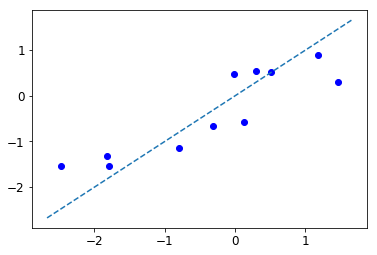

('Training Set: [46, 19, 50, 54, 26, 0, 35, 53, 2, 4, 29, 42, 17, 6, 10, 21, '
 '41, 14, 44, 24, 32, 7, 47, 34, 13, 37, 25, 3, 28, 8, 45, 52, 40, 38, 51, 16, '
 '23, 5, 36, 18, 15, 48, 22, 33]')
'Test Set: [1, 11, 43, 49, 27, 20, 9, 30, 31, 12, 39]'
0.372501083051
Pearson: (0.88411675307434401, 0.00030328110115060132)
Spearman: SpearmanrResult(correlation=0.74545454545454559, pvalue=0.0084547288850615604)


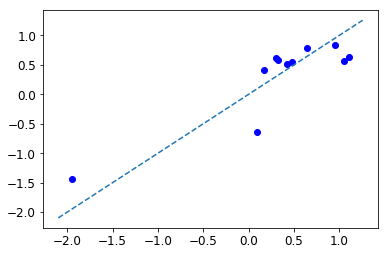

('Training Set: [30, 24, 2, 4, 6, 3, 8, 41, 20, 35, 23, 45, 36, 19, 15, 14, '
 '21, 0, 54, 39, 40, 50, 12, 38, 29, 51, 7, 52, 44, 9, 1, 27, 11, 18, 31, 37, '
 '22, 10, 32, 43, 53, 42, 47, 16]')
'Test Set: [49, 46, 17, 26, 28, 34, 48, 33, 25, 13, 5]'
0.488220829275
Pearson: (0.91197538501923525, 9.1722915415935898e-05)
Spearman: SpearmanrResult(correlation=0.82727272727272727, pvalue=0.001676973896452378)


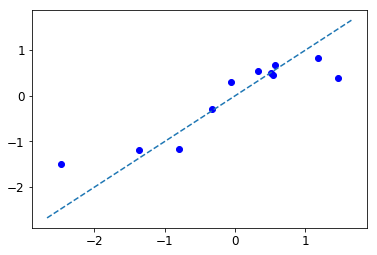

('Training Set: [38, 50, 4, 51, 53, 5, 24, 14, 15, 40, 35, 7, 52, 17, 28, 23, '
 '49, 3, 36, 48, 30, 19, 43, 41, 29, 22, 12, 47, 21, 20, 16, 11, 26, 45, 44, '
 '6, 25, 46, 34, 54, 37, 32, 8, 33]')
'Test Set: [1, 39, 13, 10, 9, 27, 2, 31, 42, 0, 18]'
0.305513933397
Pearson: (0.90541224067765858, 0.0001255427487111723)
Spearman: SpearmanrResult(correlation=0.24545454545454545, pvalue=0.46692236698201628)


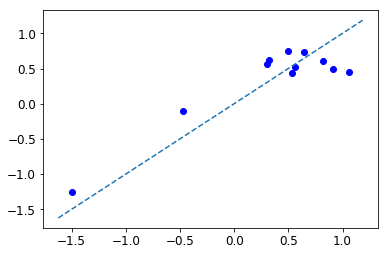

('Training Set: [26, 7, 6, 41, 1, 43, 39, 22, 40, 14, 54, 8, 12, 28, 46, 42, '
 '27, 31, 30, 53, 16, 45, 3, 21, 52, 33, 29, 44, 24, 18, 36, 51, 20, 17, 2, '
 '11, 37, 19, 47, 5, 34, 9, 23, 0]')
'Test Set: [50, 38, 15, 48, 35, 32, 10, 13, 49, 4, 25]'
0.617258518886
Pearson: (0.84971642314194196, 0.00092757678485431538)
Spearman: SpearmanrResult(correlation=0.90000000000000002, pvalue=0.00015997142806871369)


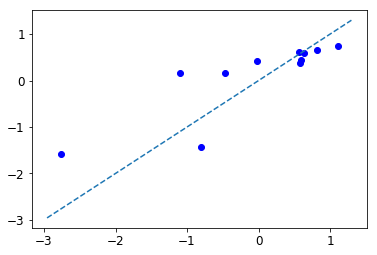

('Training Set: [39, 44, 36, 25, 19, 35, 11, 2, 52, 37, 29, 34, 49, 22, 12, 1, '
 '46, 45, 14, 10, 5, 26, 53, 3, 54, 48, 15, 13, 33, 41, 38, 21, 42, 40, 20, '
 '51, 31, 4, 0, 23, 16, 30, 27, 17]')
'Test Set: [8, 18, 47, 6, 50, 7, 24, 43, 32, 28, 9]'


In [63]:
for label in labels:
    # Remove uneeded labels
    selected_training_set = final_training_set.iloc[:, list([label]) + list(range(5,final_training_set.shape[1]))].copy()
    selected_training_set = selected_training_set[np.isfinite(selected_training_set.iloc[:,1])]
    training_set, testing_set = split_train_test(selected_training_set, test_ratio = 0.20)
    model_data = training_set.copy().drop([training_set.columns[0], training_set.columns[1]], axis = 1)
    model_labels = training_set.iloc[:,1]
    lasso = RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
    lasso.fit(model_data, model_labels)
    model_test_data = testing_set.copy().drop([training_set.columns[0], training_set.columns[1]], axis = 1)
    model_test_labels = testing_set.iloc[:,1]
    predictions = lasso.predict(model_test_data)
    mse = mean_squared_error(model_test_labels, predictions)
    rmse = np.sqrt(mse)
    print(rmse)
    r = scipy.stats.pearsonr(model_test_labels, predictions)
    t = scipy.stats.spearmanr(model_test_labels, predictions)
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    plt.plot(model_test_labels, predictions, 'bo')
    abline(1,0)
    plt.show()
    
    pprint("Training Set: " + str(list(model_data.index)))
    pprint("Test Set: " + str(list(model_test_data.index)))



### TODO: Work on cross validation

0.446677662896
Pearson: (0.94260987037330701, 1.3999323155267139e-05)
Spearman: SpearmanrResult(correlation=0.94545454545454544, pvalue=1.1183037701493191e-05)


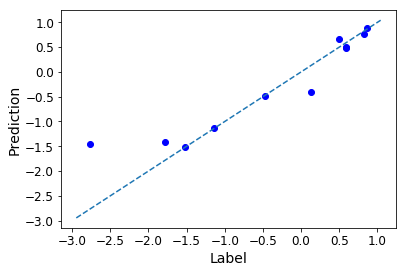

('Training Set: [39, 18, 52, 7, 49, 33, 22, 43, 5, 41, 14, 29, 37, 28, 26, 36, '
 '25, 40, 0, 48, 10, 54, 15, 13, 34, 51, 3, 27, 42, 12, 16, 2, 4, 31, 8, 46, '
 '24, 1, 35, 9, 17, 47, 53, 11]')
'Test Set: [44, 20, 50, 23, 19, 21, 6, 38, 45, 30, 32]'
[-0.28458206 -0.22713347 -0.1137794  -0.07879004 -0.05086827 -0.3698765
 -0.25589123 -0.64258443 -0.11718488 -0.06516086]
-0.220585115322
0.173470969189


In [64]:
label = 1
# Remove uneeded labels
selected_training_set = final_training_set.iloc[:, list([label]) + list(range(5,final_training_set.shape[1]))].copy()


selected_training_set = selected_training_set[np.isfinite(selected_training_set.iloc[:,1])]
trainimputer = Pipeline([
    ('imputer', Imputer(strategy="median"))
])
imputed = imputer.fit_transform(selected_training_set)

selected_training_set = pd.DataFrame(data=imputed, columns = selected_training_set.columns[])

standardizer = Pipeline([
    ('std_scaler', StandardScaler())
])



training_set, testing_set = split_train_test(selected_training_set, test_ratio = 0.20)
model_data = training_set.copy().drop([training_set.columns[0], training_set.columns[1]], axis = 1)
model_labels = training_set.iloc[:,1]
lasso = RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
lasso.fit(model_data, model_labels)
model_test_data = testing_set.copy().drop([training_set.columns[0], training_set.columns[1]], axis = 1)
model_test_labels = testing_set.iloc[:,1]
predictions = lasso.predict(model_test_data)
mse = mean_squared_error(model_test_labels, predictions)
rmse = np.sqrt(mse)
print(rmse)
r = scipy.stats.pearsonr(model_test_labels, predictions)
t = scipy.stats.spearmanr(model_test_labels, predictions)
print("Pearson: " + str(r))
print("Spearman: " + str(t))
plt.plot(model_test_labels, predictions, 'bo')
abline(1,0)
plt.ylabel("Prediction")
plt.xlabel("Label")
plt.show()

pprint("Training Set: " + str(list(model_data.index)))
pprint("Test Set: " + str(list(model_test_data.index)))
    
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lasso, model_data, model_labels,
                         scoring = "neg_mean_squared_error", cv=10)
print(scores)
print(scores.mean())
print(scores.std())

In [54]:
print(scores)
print(scores.mean())
print(scores.std())

[-0.08512928 -0.15128812 -0.17962749 -0.04088295 -0.02215305 -0.41522007
 -0.38944248 -0.49322433 -0.06349922 -0.13216537]
-0.197263236108
0.162566503017


In [66]:
print(predictions)

[ 0.50221016 -1.42054177  0.77134062 -1.13911301  0.47254484  0.88139077
 -1.45556921  0.67365493 -1.5121182  -0.40998143 -0.49404172]


In [65]:

standardizer.inverse_transform(predictions)

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:475: FutureWarning: From version 0.19, a 1d X will not be reshaped in pipeline.inverse_transform any more.
  " pipeline.inverse_transform any more.", FutureWarning)


ValueError: operands could not be broadcast together with shapes (1,11) (30,) (1,11) 